In [1]:
%%capture
%run GPTarchitecture.ipynb

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [3]:
# import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [4]:
# Calculating the text generation loss: cross-entropy and perplexity
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [5]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [9]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [10]:
"""The goal is to get the average log probability as close to 0 as possible by
updating the model's weights as part of the training process"""
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [11]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [12]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [13]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [14]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [15]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


In [16]:
# Load and preprocess text files
from datasets import load_dataset

ds = load_dataset("A2H0H0R1/Animal-nutrition")

text_data = ""

# Iterate through the first 100 samples
for sample in ds['train'][:100]['text']:
    # Strip leading and trailing whitespace
    cleaned_text = sample.strip()
    # Check if text is not empty
    if cleaned_text:
        # Add cleaned text and a newline for separation
        text_data += cleaned_text  # Two newlines for separation
text_data = text_data.replace("Question: ", "").replace("Answer: ", "")

In [17]:
"""
# Uncomment the following code block in order to execute the train with Animal nutrition dataset
import os

def combine_texts(text_dir):
    combined_text = ""
    files_processed = 0
    for filename in os.listdir(text_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(text_dir, filename), 'r', encoding='utf-8') as file:
                combined_text += file.read() + "\n"  # Add a newline to separate contents of different files
                files_processed += 1
                if files_processed >= 20:
                    break

    return combined_text

text_data = combine_texts("openwebtext")
"""

'\n# Uncomment the following code block in order to execute the train with Animal nutrition dataset\nimport os\n\ndef combine_texts(text_dir):\n    combined_text = ""\n    files_processed = 0\n    for filename in os.listdir(text_dir):\n        if filename.endswith(\'.txt\'):\n            with open(os.path.join(text_dir, filename), \'r\', encoding=\'utf-8\') as file:\n                combined_text += file.read() + "\n"  # Add a newline to separate contents of different files\n                files_processed += 1\n                if files_processed >= 20:\n                    break\n\n    return combined_text\n\ntext_data = combine_texts("openwebtext")\n'

In [18]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Characters: 100390
Tokens: 19364


In [19]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [20]:
# Getting dataloader from chapter 2 ...

from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [21]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [22]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256])

In [23]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)         # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123)   # For reproducibility due to the shuffling in the data loader

with torch.no_grad():    # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.955262530933727
Validation loss: 10.996375799179077


In [25]:
# for training the model ...
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [26]:
# Now, let's train the LLM using the training function defined above
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Why is water important for animals and plants?", tokenizer=tokenizer
)

execution_time_minutes = (time.time() - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.481, Val loss 9.925
Ep 1 (Step 000005): Train loss 7.759, Val loss 8.432
Ep 1 (Step 000010): Train loss 6.649, Val loss 7.494
Ep 1 (Step 000015): Train loss 5.997, Val loss 7.200
Ep 1 (Step 000020): Train loss 5.739, Val loss 6.999
Ep 1 (Step 000025): Train loss 5.527, Val loss 6.921
Ep 1 (Step 000030): Train loss 5.263, Val loss 6.655
Why is water important for animals and plants?                        The the food, and animals, and animals, and animals, and the food, and the food, and animals, and the
Ep 2 (Step 000035): Train loss 5.165, Val loss 6.559
Ep 2 (Step 000040): Train loss 4.775, Val loss 6.368
Ep 2 (Step 000045): Train loss 4.332, Val loss 6.241
Ep 2 (Step 000050): Train loss 4.315, Val loss 6.120
Ep 2 (Step 000055): Train loss 3.874, Val loss 5.898
Ep 2 (Step 000060): Train loss 4.177, Val loss 5.915
Ep 2 (Step 000065): Train loss 3.962, Val loss 5.811
Why is water important for animals and plants?                                        

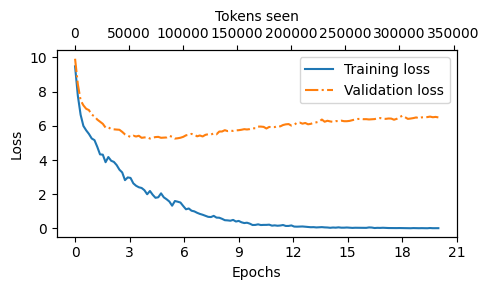

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [28]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Why is water important for animals and plants?", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k = 25,
    temperature = 1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Why is water important for animals and plants?

The chemical reactions water meat organic nutrients. On the overall nutritional value of nutrients in water can also help identify biomarkers


In [29]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "GPTtrained.pth"
)

"""
checkpoint = torch.load("GPTtrained.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();
"""

'\ncheckpoint = torch.load("GPTtrained.pth")\nmodel = GPTModel(GPT_CONFIG_124M)\nmodel.load_state_dict(checkpoint["model_state_dict"])\noptimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1optimizer.load_state_dict(checkpoint["optimizer_state_dict"])\nmodel.train();\n'